## Imports

In [92]:
import numpy as np
import pandas as pd
import networkx as nx
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
from geopy.distance import geodesic
import collections
import scipy
import operator
from functools import reduce
import community
from networkx.algorithms.community import greedy_modularity_communities
import seaborn as sns
sns.set(rc={'figure.figsize':(16,9)})
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

Originally, the data was of the form **(E =  67,663 ; N = 3,321)** :

#### route.dat
This OpenFlights/Airline Route Mapper Route Database contains 67,663 routes (EDGES) between 3,321 airports (NODES) on 548 airlines spanning the globe.

- **Airline**	2-letter (IATA) or 3-letter (ICAO) code of the airline.
- **Airline ID**	Unique OpenFlights identifier for airline (see Airline).
- **Source airport**	3-letter (IATA) or 4-letter (ICAO) code of the source airport.
- **Source airport ID**	Unique OpenFlights identifier for source airport (see Airport)
- **Destination airport**	3-letter (IATA) or 4-letter (ICAO) code of the destination airport.
- **Destination airport ID**	Unique OpenFlights identifier for destination airport (see Airport)
- **Codeshare**	"Y" if this flight is a codeshare (that is, not operated by Airline, but another carrier), empty otherwise.
- **Stops**	Number of stops on this flight ("0" for direct)
-  **Equipment**	3-letter codes for plane type(s) generally used on this flight, separated by spaces

The data is UTF-8 encoded. The special value \N is used for "NULL" to indicate that no value is available, and is understood automatically by MySQL if imported.

Notes:
Routes are directional: if an airline operates services from A to B and from B to A, both A-B and B-A are listed separately.
Routes where one carrier operates both its own and codeshare flights are listed only once.


#### airport.dat
As of January 2017, the OpenFlights Airports Database contains over **10,000 airports, train stations and ferry terminals spanning the globe, as shown in the map above. Each entry contains the following information:

- **Airport ID**	Unique OpenFlights identifier for this airport.
- **Name**	Name of airport. May or may not contain the City name.
- **City**	Main city served by airport. May be spelled differently from Name.
- **Country**	Country or territory where airport is located. See countries.dat to cross-reference to ISO 3166-1 codes.
- **IATA**	3-letter IATA code. Null if not assigned/unknown.
- **ICAO**	4-letter ICAO code. Null if not assigned.
- **Latitude**	Decimal degrees, usually to six significant digits. Negative is South, positive is North.
- **Longitude**	Decimal degrees, usually to six significant digits. Negative is West, positive is East.
- **Altitude**	In feet.
- **Timezone**	Hours offset from UTC. Fractional hours are expressed as decimals, eg. India is 5.5.
- **DST**	Daylight savings time. One of E (Europe), A (US/Canada), S (South America), O (Australia), Z (New Zealand), N (None) or U (Unknown). See also: Help: Time
- **Tz** database time zone	Timezone in "tz" (Olson) format, eg. "America/Los_Angeles".
- **Type**	Type of the airport. Value "airport" for air terminals, "station" for train stations, "port" for ferry terminals and "unknown" if not known. In airports.csv, only type=airport is included.
- **Source**	In airports.csv, only source=OurAirports is included.
The data is UTF-8 encoded.

Note: Rules for daylight savings time change from year to year and from country to country. The current data is an approximation for 2009, built on a country level. Most airports in DST-less regions in countries that generally observe DST (eg. AL, HI in the USA, NT, QL in Australia, parts of Canada) are marked incorrectly.

## Loading the datasets

In [43]:
routes = pd.read_csv('routes.dat', header=None)
routes.columns = ['Airline',
                'Airline ID',
                'Source airport',
                'Source airport ID',
                'Destination airport',
                'Destination airport ID',
                'Codeshare',
                'Stops',
                'Equipment']

airports = pd.read_csv('airports.dat', header=None, index_col=4, na_values='\\N')
airports.columns = ['Airport ID',
                    'Name',
                    'City',
                    'Country',
                    'ICAO',
                    'Latitude',
                    'Longitude',
                    'Altitude',
                    'Timezone',
                    'DST',
                    'TZ',
                    'Type',
                    'Source']

In [44]:
routes.head()

Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  
0                   2990       NaN      0       CR2  
1                   2990       NaN      0       CR2  
2                   2962       NaN      0       CR2  
3                   2990       NaN      0       CR2  
4                   4078       NaN      0       CR2

In [46]:
airports.head()

Airport ID                                         Name          City  \
4                                                                            
GKA           1                               Goroka Airport        Goroka   
MAG           2                               Madang Airport        Madang   
HGU           3                 Mount Hagen Kagamuga Airport   Mount Hagen   
LAE           4                               Nadzab Airport        Nadzab   
POM           5  Port Moresby Jacksons International Airport  Port Moresby   

              Country  ICAO  Latitude   Longitude  Altitude  Timezone DST  \
4                                                                           
GKA  Papua New Guinea  AYGA -6.081690  145.391998      5282      10.0   U   
MAG  Papua New Guinea  AYMD -5.207080  145.789001        20      10.0   U   
HGU  Papua New Guinea  AYMH -5.826790  144.296005      5388      10.0   U   
LAE  Papua New Guinea  AYNZ -6.569803  146.725977       239      10.0   U   
POM  Papua New Guinea  AYPY -9.443380  147.220001       146      10.0   U   

                       TZ     Type       Source  
4                                                
GKA  Pacific/Port_Moresby  airport  OurAirports  
MAG  Pacific/Port_Moresby  airport  OurAirports  
HGU  Pacific/Port_Moresby  airport  OurAirports  
LAE  Pacific/Port_Moresby  airport  OurAirports  
POM  Pacific/Port_Moresby  airport  OurAirports

## Cleaning

In [ ]:
#Find common airport between both datasets airport.dat and route.dat
airports_route = list(set(set(routes['Source airport']) | set(routes['Destination airport'])))
airports_air = list(airports.index)
nodes = list(set(airports_air) & set(airports_route))

#We keep the edges that start and arrive at know airports
routes_clean = routes[(routes['Source airport'].isin(nodes)) & (routes['Destination airport'].isin(nodes))]
airports_clean = airports[airports.index.isin(nodes)]

In [58]:
#We add the lat.long for starting and arriving airports and the distance of the route(5 columns)
routes_clean['Source latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Source longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Destination latitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Latitude.values.item(0), axis = 1)
routes_clean['Destination longitude'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Longitude.values.item(0), axis = 1)
routes_clean['Distance'] = routes_clean.apply(lambda row : geodesic((row['Source latitude'], row['Source longitude']), (row['Destination latitude'], row['Destination longitude'])).kilometers, axis = 1)

In [60]:
routes_clean.head()

Airline Airline ID Source airport Source airport ID Destination airport  \
0      2B        410            AER              2965                 KZN   
1      2B        410            ASF              2966                 KZN   
2      2B        410            ASF              2966                 MRV   
3      2B        410            CEK              2968                 KZN   
4      2B        410            CEK              2968                 OVB   

  Destination airport ID Codeshare  Stops Equipment  Source latitude  \
0                   2990       NaN      0       CR2        43.449902   
1                   2990       NaN      0       CR2        46.283298   
2                   2962       NaN      0       CR2        46.283298   
3                   2990       NaN      0       CR2        55.305801   
4                   4078       NaN      0       CR2        55.305801   

   Source longitude  Destination latitude  Destination longitude     Distance  
0         39.956600             55.606201              49.278702  1507.989717  
1         48.006302             55.606201              49.278702  1040.943207  
2         48.006302             44.225101              43.081902   449.036664  
3         61.503300             55.606201              49.278702   773.126239  
4         61.503300             55.012600              82.650703  1343.161122

**Save the clean data**

In [61]:
routes_clean.to_csv('routes_clean.csv', index=False)
airports_clean.to_csv('airports_clean.csv')

## Data Exploration

**Load clean data**

In [77]:
routes = pd.read_csv('routes_clean.csv', low_memory=False)
airports = pd.read_csv('airports_clean.csv', index_col=0)

**Create graph using networkx from a list of edges**

In [78]:
#we can add attributes here
G = nx.from_pandas_edgelist(routes, 'Source airport', 'Destination airport', ['Distance'])

**Statistics to explore**
- average degree
- connected components
- diameter
- centrality measures (computed from the shortest paths)
- graph density
- pagerank
- eigenvector centrality

### Degree ditribution

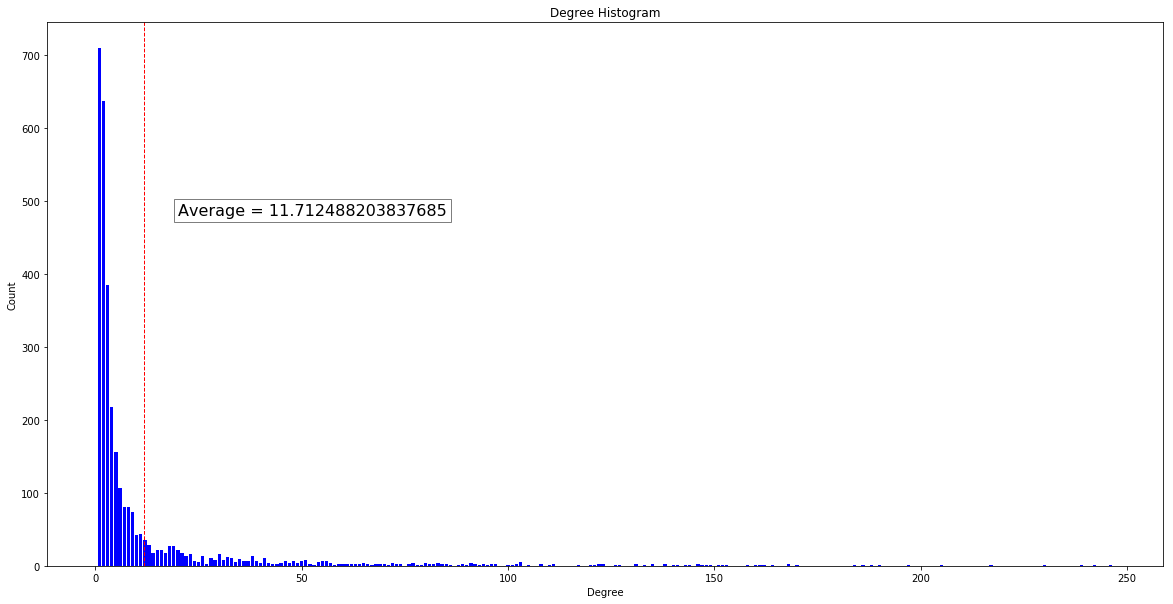

In [79]:
degree_sequence = sorted([d for n, d in G.degree()], reverse=True)  # degree sequence
# print "Degree sequence", degree_sequence
degreeCount = collections.Counter(degree_sequence)
deg, cnt = zip(*degreeCount.items())

fig, ax = plt.subplots(figsize = (20,10))
plt.bar(deg, cnt, width=0.80, color='b')
mean = np.array(degree_sequence).mean()
plt.axvline(mean, color='r', linestyle='dashed', linewidth=1)
plt.title("Degree Histogram")
plt.ylabel("Count")
plt.xlabel("Degree")
plt.text(20,480,'Average = {}'.format(mean),bbox=dict(facecolor='white', alpha=0.5), fontsize=16)
plt.show()

## Graph connectivity

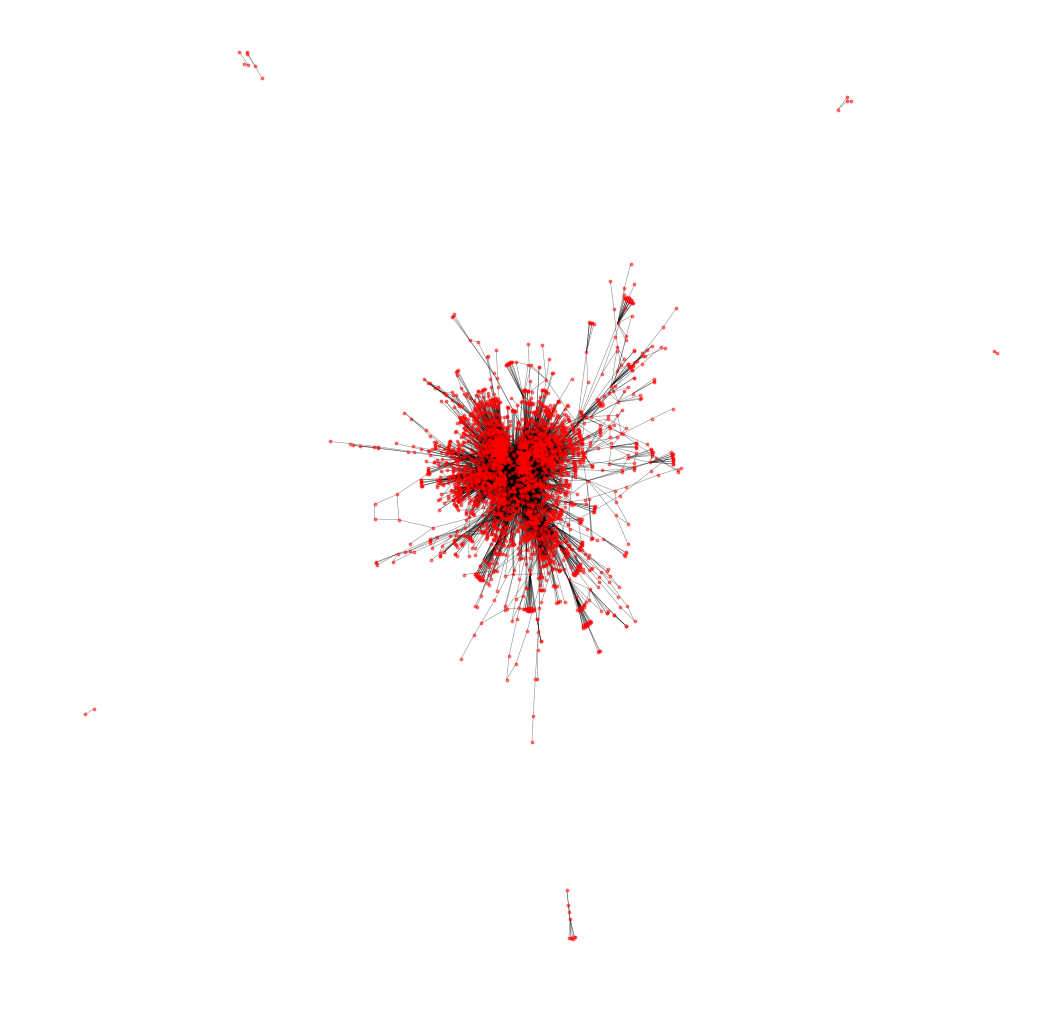

In [80]:
fig, ax = plt.subplots(1, 1, figsize=(18, 18))
nx.draw_networkx(G, ax=ax, node_size=8, alpha=.5,
                 width=.5, with_labels=False)
ax.set_axis_off()

In [82]:
print("We can see that our graph is not connected. In fact, there are", nx.number_connected_components(G), "components in total.")

We can see that our graph is not connected. In fact, there are 7 components in total.


In [83]:
largest_cc = max(nx.connected_component_subgraphs(G), key=len)

In [86]:
print("We get the largest connected component for the continuation. It contains", len(largest_cc),"nodes.")

We get the largest connected component for the continuation. It contains 3154 nodes.


### Largest component diameter 

In [87]:
print("The diameter of the graph is the length of the longest shortest path between any pair of nodes.")
print("The diameter of our graph is", nx.diameter(largest_cc))

The diameter of the graph is the length of the longest shortest path between any pair of nodes.
The diameter of our graph is 12


### Clutering coefficient

**The neighborhood of a node u, is the set of nodes that are connected to u**. The clustetring coefficient of a node  **u**  is the fraction of the node’s neighbors that are connected. Finally, we obtain the average clustering coefficient by averaging this value over all nodes of the graph.

In [88]:
print("Our graph has a clustering coefficient of", nx.average_clustering(largest_cc))

Our graph has a clustering coefficient of 0.49144436995862


### Centrality

Centrality is a mesure of importance of nodes/edges in a network

In [90]:
#Helper functions
def get_NameCity(ID):
    row = airports.loc[ID]
    return row['Name'], row['City']

def plot_dict(dict_, k, name):
    

    def print_rank(l):
        for k in range(len(l)):

            a,b = get_NameCity(l[k])
            print('{}. {}, {}'.format(k+1,a,b))
            
    
    airports, values = list(dict_.keys()), list(dict_.values())
    sort_index = list(np.argsort(values))
    airports_s = np.array(airports)[sort_index][::-1] #k highest ranked
    values_s = np.array(values)[sort_index][::-1]

    sns.barplot(x=airports_s[:k], y=values_s[:k],palette="deep", label='small')
    
    print('- In means of {} : Top 15 respectively are : '.format(name,k))
    print_rank(airports_s[:k])
    return list(zip(airports_s, np.array(range(len(airports_s)))+1))


#### Betweenness centrality:
Betweenness centrality mesures how much nodes/edges are part of shortest paths

- In means of betweenness : Top 15 respectively are : 
1. Charles de Gaulle International Airport, Paris
2. Los Angeles International Airport, Los Angeles
3. Dubai International Airport, Dubai
4. Ted Stevens Anchorage International Airport, Anchorage
5. Frankfurt am Main International Airport, Frankfurt
6. Amsterdam Airport Schiphol, Amsterdam
7. Beijing Capital International Airport, Beijing
8. Chicago O'Hare International Airport, Chicago
9. Lester B. Pearson International Airport, Toronto
10. Atatürk International Airport, Istanbul
11. Guarulhos - Governador André Franco Montoro International Airport, Sao Paulo
12. London Heathrow Airport, London
13. Narita International Airport, Tokyo
14. Sydney Kingsford Smith International Airport, Sydney
15. Seattle Tacoma International Airport, Seattle


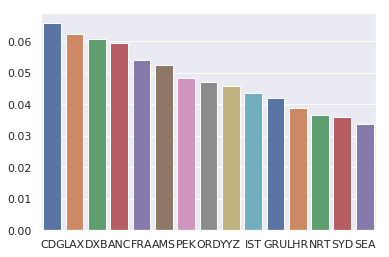

In [93]:
betweenness = nx.betweenness_centrality(largest_cc)
bet_sort = plot_dict(betweenness,15,'betweenness')


#### Eigenvalue centrality:
Eigenvalue centrality mesures how much nodes are connected to nodes with high betweenness centrality

- In means of eigenvectors : Top 15 respectively are : 
1. Amsterdam Airport Schiphol, Amsterdam
2. Frankfurt am Main International Airport, Frankfurt
3. Charles de Gaulle International Airport, Paris
4. Munich International Airport, Munich
5. Leonardo da Vinci–Fiumicino Airport, Rome
6. London Heathrow Airport, London
7. Barcelona International Airport, Barcelona
8. Atatürk International Airport, Istanbul
9. Zürich Airport, Zurich
10. Adolfo Suárez Madrid–Barajas Airport, Madrid
11. Brussels Airport, Brussels
12. Dublin Airport, Dublin
13. Düsseldorf International Airport, Duesseldorf
14. London Gatwick Airport, London
15. Manchester Airport, Manchester


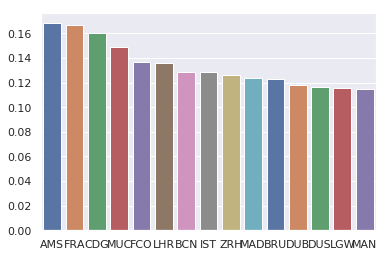

In [94]:
eigenve = nx.eigenvector_centrality(largest_cc)
eig_sort = plot_dict(eigenve, 15, 'eigenvectors')

### PageRank
PageRank is a variant of eigenvalue centrality

- In means of pagerank : Top 15 respectively are : 
1. Hartsfield Jackson Atlanta International Airport, Atlanta
2. Chicago O'Hare International Airport, Chicago
3. Dallas Fort Worth International Airport, Dallas-Fort Worth
4. Atatürk International Airport, Istanbul
5. Denver International Airport, Denver
6. Charles de Gaulle International Airport, Paris
7. Domodedovo International Airport, Moscow
8. Amsterdam Airport Schiphol, Amsterdam
9. Frankfurt am Main International Airport, Frankfurt
10. Dubai International Airport, Dubai
11. Beijing Capital International Airport, Beijing
12. George Bush Intercontinental Houston Airport, Houston
13. Los Angeles International Airport, Los Angeles
14. Sydney Kingsford Smith International Airport, Sydney
15. Lester B. Pearson International Airport, Toronto


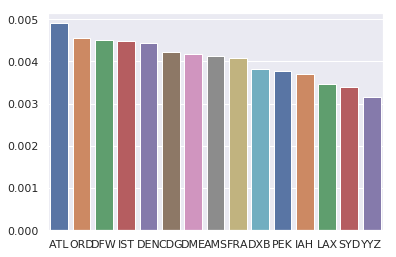

In [95]:
pagerank = nx.pagerank(largest_cc)
pr_sort = plot_dict(pagerank, 15, 'pagerank')

In [96]:
bt = pd.DataFrame(bet_sort, columns = ['Airport ID', 'Betweenness']) 
eg = pd.DataFrame(eig_sort, columns = ['Airport ID', 'EigenVectors']) 
pr = pd.DataFrame(pr_sort, columns = ['Airport ID', 'PageRank']) 

dfs = [bt, eg, pr]
df_final = reduce(lambda left,right: pd.merge(left,right,on='Airport ID'), dfs)
df_final['Average'] = (df_final['Betweenness']+df_final['EigenVectors']+df_final['PageRank'])/3
df_final.sort_values('Average',inplace=True)
df_final.reset_index(drop = True,inplace=True)
df_final['OverAll Rank'] = np.array(df_final.index)+1
df_final.set_index('Airport ID',inplace=True)
namecity = pd.Series(df_final.index).apply(lambda x : str('{}, {}'.format(get_NameCity(x)[0],get_NameCity(x)[1])))
df_final.reset_index(inplace=True)
df_final['Airport Name, City'] = namecity
df_final.set_index('Airport ID',inplace=True)
df_final.head(15)

Betweenness  EigenVectors  PageRank    Average  OverAll Rank  \
Airport ID                                                                 
CDG                   1             3         6   3.333333             1   
AMS                   6             1         8   5.000000             2   
FRA                   5             2         9   5.333333             3   
IST                  10             8         4   7.333333             4   
DXB                   3            20        10  11.000000             5   
ORD                   8            28         2  12.666667             6   
LHR                  12             6        20  12.666667             7   
YYZ                   9            29        15  17.666667             8   
PEK                   7            37        11  18.333333             9   
ATL                  19            36         1  18.666667            10   
JFK                  25            18        16  19.666667            11   
LAX                   2            45        13  20.000000            12   
MAD                  31            10        28  23.000000            13   
MUC                  43             4        24  23.666667            14   
DME                  20            48         7  25.000000            15   

                                           Airport Name, City  
Airport ID                                                     
CDG            Charles de Gaulle International Airport, Paris  
AMS                     Amsterdam Airport Schiphol, Amsterdam  
FRA         Frankfurt am Main International Airport, Frank...  
IST                   Atatürk International Airport, Istanbul  
DXB                        Dubai International Airport, Dubai  
ORD             Chicago O'Hare International Airport, Chicago  
LHR                           London Heathrow Airport, London  
YYZ          Lester B. Pearson International Airport, Toronto  
PEK            Beijing Capital International Airport, Beijing  
ATL         Hartsfield Jackson Atlanta International Airpo...  
JFK            John F Kennedy International Airport, New York  
LAX            Los Angeles International Airport, Los Angeles  
MAD              Adolfo Suárez Madrid–Barajas Airport, Madrid  
MUC                      Munich International Airport, Munich  
DME                  Domodedovo International Airport, Moscow

The above Dataframe shows the ranking ok nodes in term ok centrality

## World map

To create the map, we first retrieve the coordinates from the airports dataframe

In [67]:
pos = {airport: (v['Longitude'], v['Latitude'])
       for airport, v in
       airports.to_dict('index').items()}

Node size will be the degree of the nodes

In [68]:
deg = nx.degree(largest_cc)
sizes = [5 * deg[iata] for iata in largest_cc.nodes]

Display label only if degree is quite big

In [69]:
labels = {iata: iata if deg[iata] >= 200 else ''
          for iata in largest_cc.nodes}

In [70]:
def display_map(graph, node_color=None):
    # Map projection
    fig, ax = plt.subplots(
        1, 1, figsize=(36, 24),
        subplot_kw=dict(projection=ccrs.PlateCarree()))
    ax.coastlines()

    # Extent of continental US.
    #ax.set_extent([-128, -62, 20, 50])
    nx.draw_networkx(graph, ax=ax,
                     font_size=20,
                     alpha=.5,
                     width=.075,
                     node_size=sizes,
                     labels=labels,
                     pos=pos,
                     node_color=node_color)

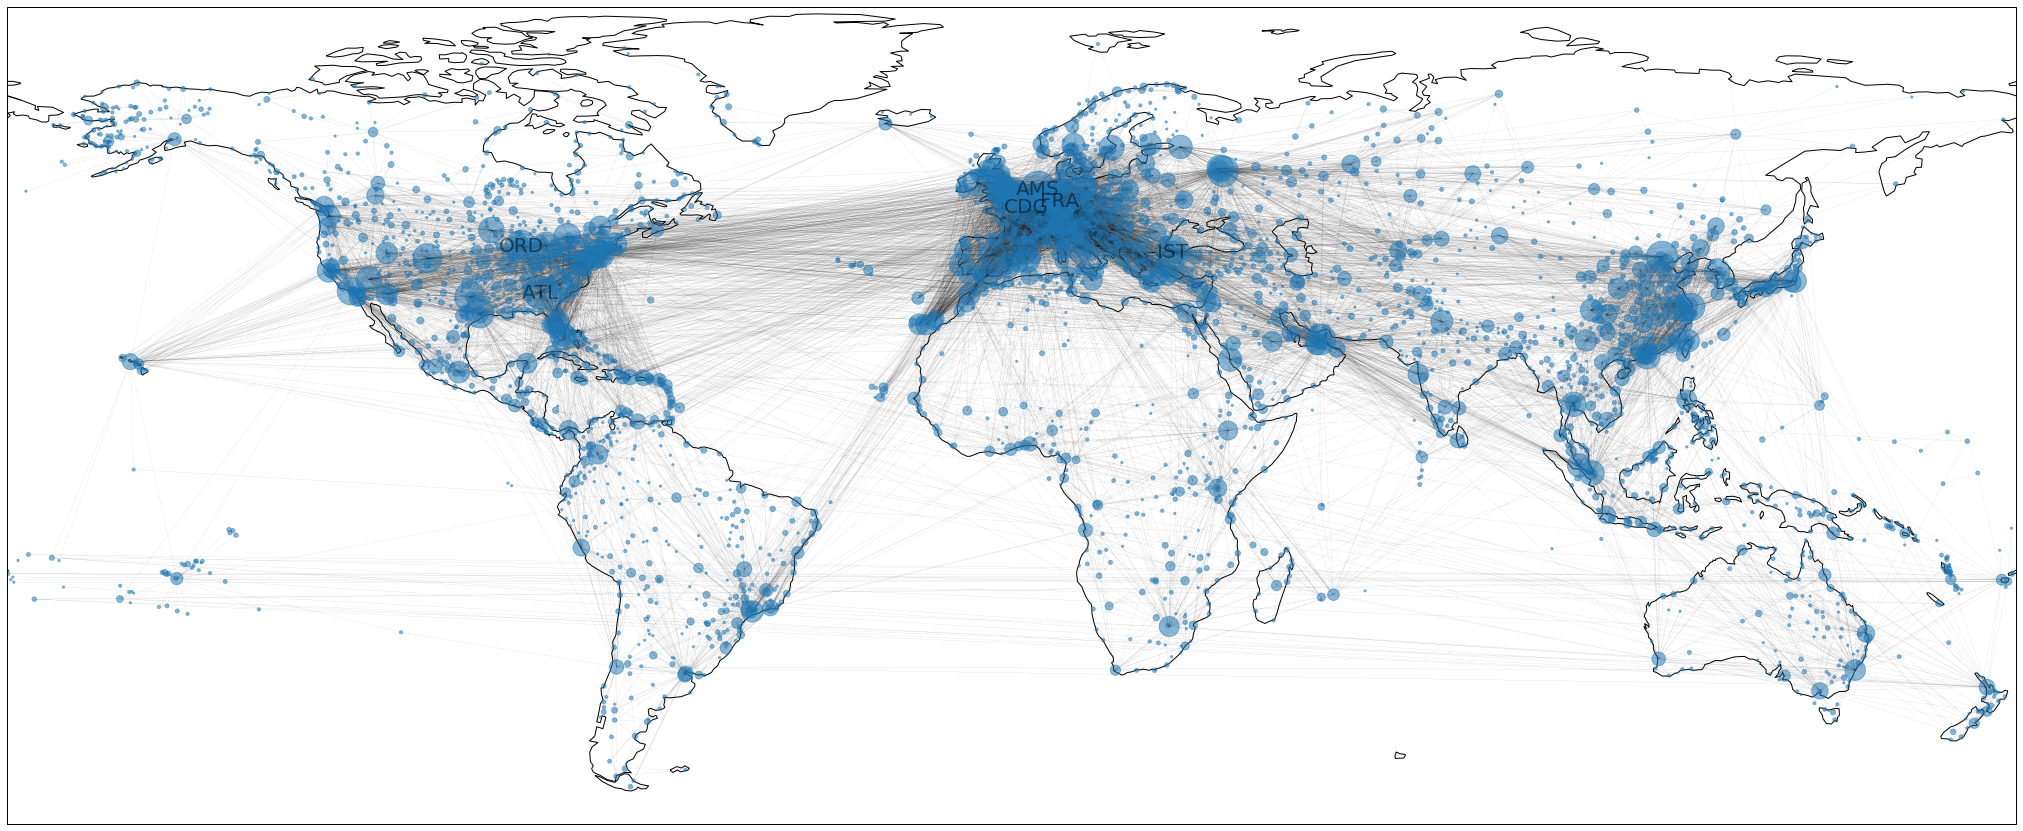

In [71]:
display_map(largest_cc)

## Flight distance

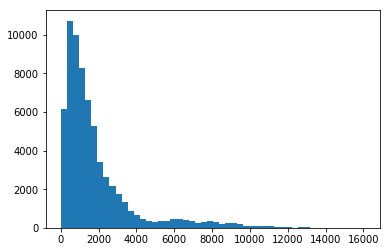

In [72]:
plt.hist(routes_clean['Distance'].values, bins = 50)
plt.show()

The distribution of distances follows a power law with most fly being relatively short distances.

## Local/international flights

In [73]:
routes_clean['Source country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Source airport ID'])].Country.values.item(0), axis = 1)
routes_clean['Destination country'] = routes_clean.apply(lambda row : airports_clean[airports_clean['Airport ID'] == int(row['Destination airport ID'])].Country.values.item(0), axis = 1)

In [74]:
routes_clean['International flight'] = routes_clean.apply(lambda row : not (row['Source country'] == row['Destination country']), axis = 1)

In [75]:
routes_clean['International flight'].value_counts()

True     34222
False    31845
Name: International flight, dtype: int64

We have an even distribution of international and national flights

In [76]:
routes_clean[['Source airport', 'Source airport ID', 'Source country']].groupby(['Source airport', 'Source country']).count().sort_values(by = ['Source airport ID'], ascending = False).head()

Source airport ID
Source airport Source country                   
ATL            United States                 915
ORD            United States                 556
LHR            United Kingdom                523
CDG            France                        523
PEK            China                         520

5 most used airports

## Finding communities with Spectral Clustering

In order to perform spectral clustering on our graph, we will first need to compute the laplacian of our graph:

In [155]:
laplacian = nx.laplacian_matrix(largest_cc)
laplacian = laplacian.asfptype()

We will now compute an embedding of our graph, in order to visualize it in 2 dimensions and also to use a representation in higher dimension, for the clustering.

We define a function below to compute such an embedding. As seen in class, we will compute an eigendecomposition of the laplacian, in an efficient way. That is, if we choose to embed in $k$ dimensions, we will only need to compute the first $k$ eigenvectors.

In [173]:
def compute_embedding(laplacian, dim):
    """Given a graph laplacian and a target dimension, this function
    computes a graph embedding in the chosen dimension. There is the
    option to normalize the eigenvectors in the process."""
    
    #Compute the k first eigenvectors (k depends on the target dimension)
    k_eigenvalues, k_eigenvectors = scipy.sparse.linalg.eigsh(laplacian, k=1+dim, which='SA')        

    #Compute the embedding for each node
    embedding = np.zeros((3154, dim))
    for i in range(3154):
        for k_th in range(dim): 
            embedding[i, k_th] = k_eigenvectors[i, 1+k_th]
            
    return embedding



We decided to compute an embedding in 4 dimensions:

In [180]:
embedding = compute_embedding(laplacian, 4)

Here, we show a graph for a 2D embedding, to have a visualization of the communities in our graph:

In [158]:
# Laplacian eigenmaps (coordinates in 2D)
coords = embedding[:, 0:2]

def plot_signal(signal):
    """Display nodes of the graph in 2D
    together with the given signal"""
    
    nodes = nx.draw_networkx_nodes(largest_cc, dict(zip(largest_cc.nodes, coords)), node_size=30, node_color=signal)
    plt.xlabel('Value of $\lambda_1$')
    plt.ylabel('Value of $\lambda_2$')
    plt.colorbar(nodes)



We plot here the 2D embedding of our graph, together with the first eigenvectors (the Fourier basis) as signals. This way, we hope to see how the graph could be clustered.

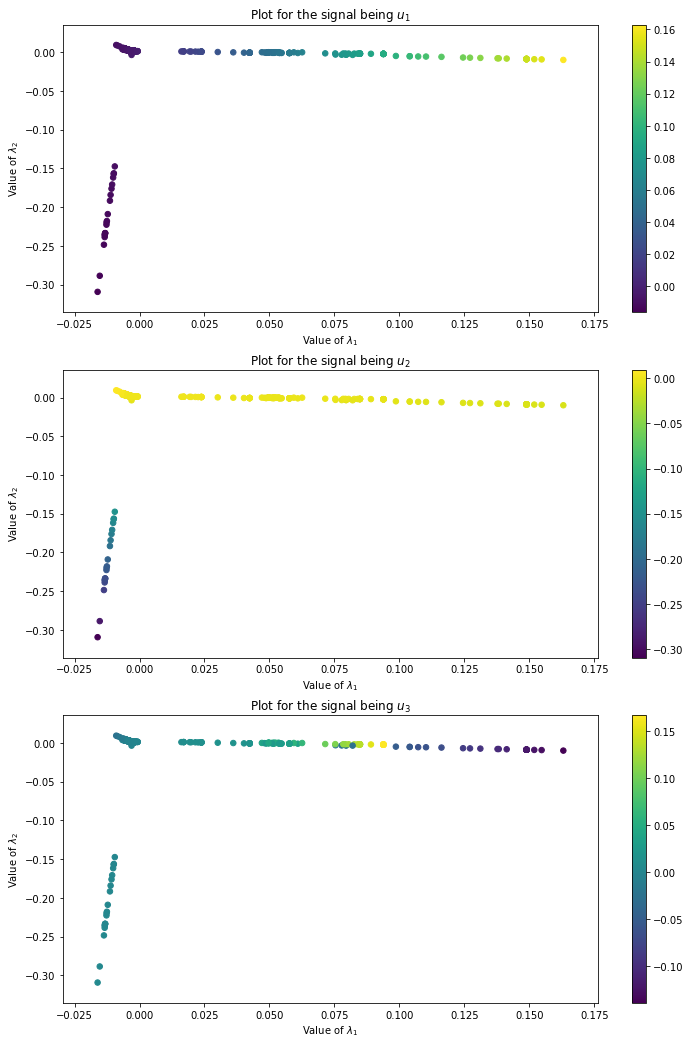

In [159]:
plt.figure(figsize=(12, 18))

# Plot the first 3 Fourier basis vectors
for i in range(3):
    plt.subplot(311 + i)
    plot_signal(embedding[:, i])
    plt.title('Plot for the signal being $u_{'+ str(1 + i)+'}$')

plt.show()



From there, we see that there are 3 blobs of points, which may suggest 3 communities. Moreover, the values of the signals change in a certain way that also suggest 2 or more clusters. 
So it seems that with this method, we won't be able to discover the continents just from the graph. 

Still in the next part, we compute a clustering with 3 clusters, as suggested before, in order to then visualize the cluster on the world map, to maybe see some of the continents as communities.

In order to really compute a clustering, we will use a Gaussian Mixture modelwith the EM algorithm.
Using the GMM model will allow us to have clusters that are non-spherical. We perform the clustering on the embedding of dimension 4.

In [160]:
predictions_gmm = GMM(n_components=3, covariance_type='full').fit_predict(embedding)

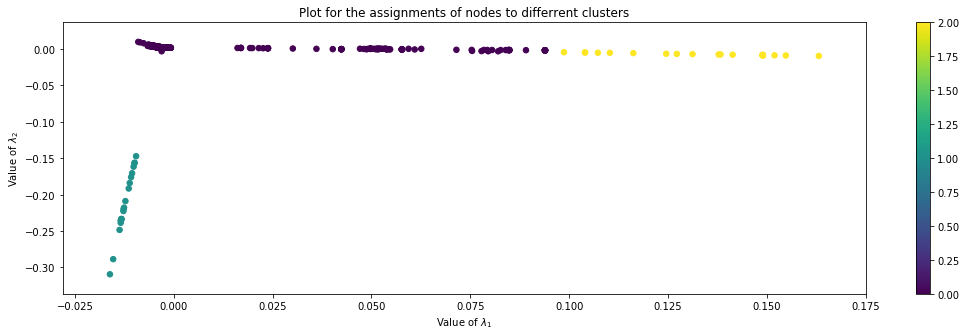

In [161]:
plt.figure(figsize=(18, 5))

plot_signal(predictions_gmm)
plt.title('Plot for the assignments of nodes to differrent clusters')

plt.show()

We now visualize thos 3 clusters directly on the world map:

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


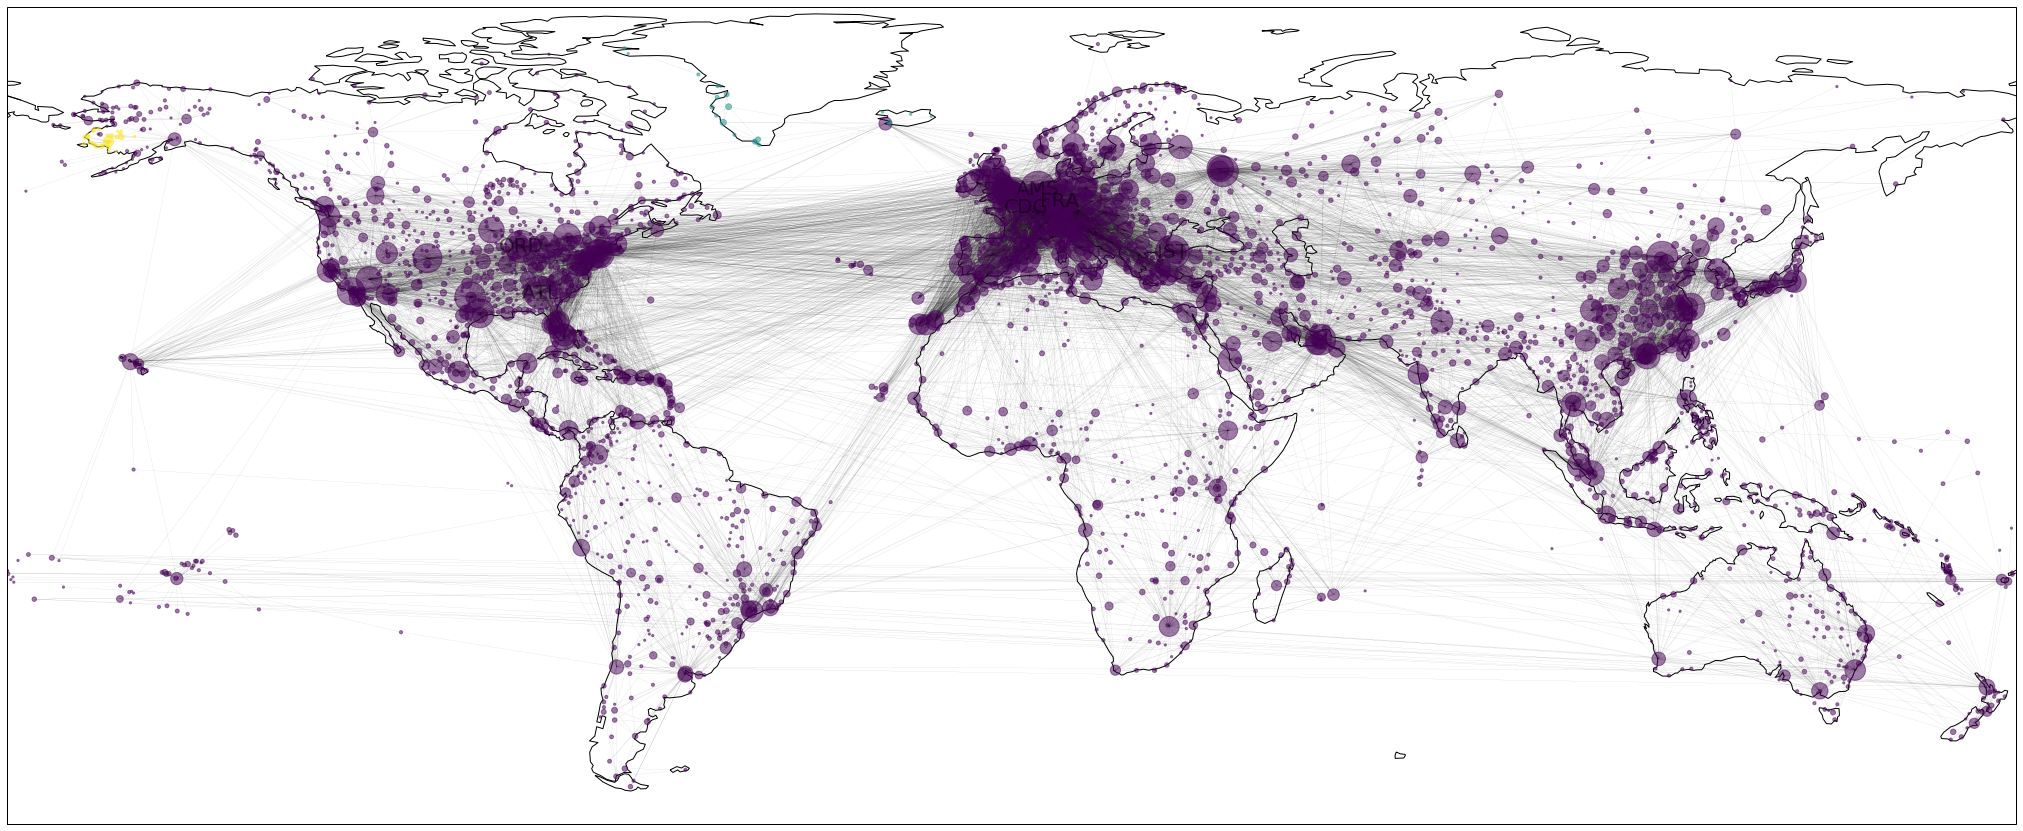

In [162]:
display_map(largest_cc, predictions_gmm)

So we see there that when using spectral clustering, it consider most of the graph as one community. We can actually see a small community in Greenland, and another one in Alaska. It is the case since those airports are almost not connected to the rest of the world, forming a community of their own.

Actually, by also computing the full eigendecomposition, and plotting the eigenvalues index against their actual value, we see the following:

(Note that we only plot the 20 first eigenvalues for a better visualization)

In [183]:
e, U = scipy.linalg.eigh(laplacian.toarray())

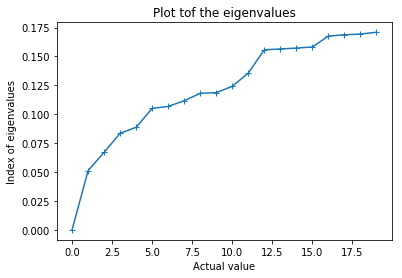

In [208]:
plt.plot(e[:20], '+-')
plt.xlabel('Actual value')
plt.ylabel('Index of eigenvalues')
plt.title('Plot tof the eigenvalues')

plt.show()

When using of spectral clustering as a mean to find communities, the plot above can help to find the number of communities. Indeed, what we call the "spectral gap" is supposed to indicate this number. It can be identified by a big gap in value between two successive eigenvalues.<br/>
Note that we can see such a gap only between the first two eigenvalues, suggesting that indeed there are only 2 communities. So it seems that via spectral clustering, it is not possible to recover the continents.

A reason why it is the case is that spectral clustering works well when there are **clear** clusters, which is not the case there. Even though there can be many connections within a continent, it can happen that there are also many edges between two continents (think of America and Europe for example).

Is it still possible to find communities in our network corresponding to the continents via other methods?


## Finding communities by modularity maximization

Another popular way for detecting communities in a graph is by maximizing a quantity called ***modularity***. Modularity is a measure of the quality of a particular partition of a network into communities. The higher the modularity, the better the partition is. Indeed, networks with high modularity have many edges between nodes in the same community but very few edges between nodes in different communities.

So a natural way to find a good partition is simply to find one which has the maximum modularity, between all possible partitions. This is of course not possible, because of time complexity reasons, and so we present algorithms such as ***Greedy Modularity Maximization***, that aim to find the a partition of the graph into communities such that the modularity is particularly high.

We will also review the ***Louvain Method***, which also aim to maximize the modularity, and turns out to be a lot more efficient than the regular greedy approach.

### Greedy Modularity Maximization

We first use the Greedy Modularity Maximization, also called CNM algorithm:

In [33]:
 c2 = nx.algorithms.community.greedy_modularity_communities(largest_cc)

We then plot on the world map the first 5 communities found by the algorithm, hoping that they will represent the continents. The other nodes are just displayed in gray:

In [34]:
size = 5
cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
list_col=[]

for node in largest_cc.nodes:
    curr_len = len(list_col)
    for i in range(size):
        if node in c2[i]:
            list_col.append(cmap(rgba[i]))
            
    if len(list_col) == curr_len:
        list_col.append((0.5, 0.5, 0.5))

/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


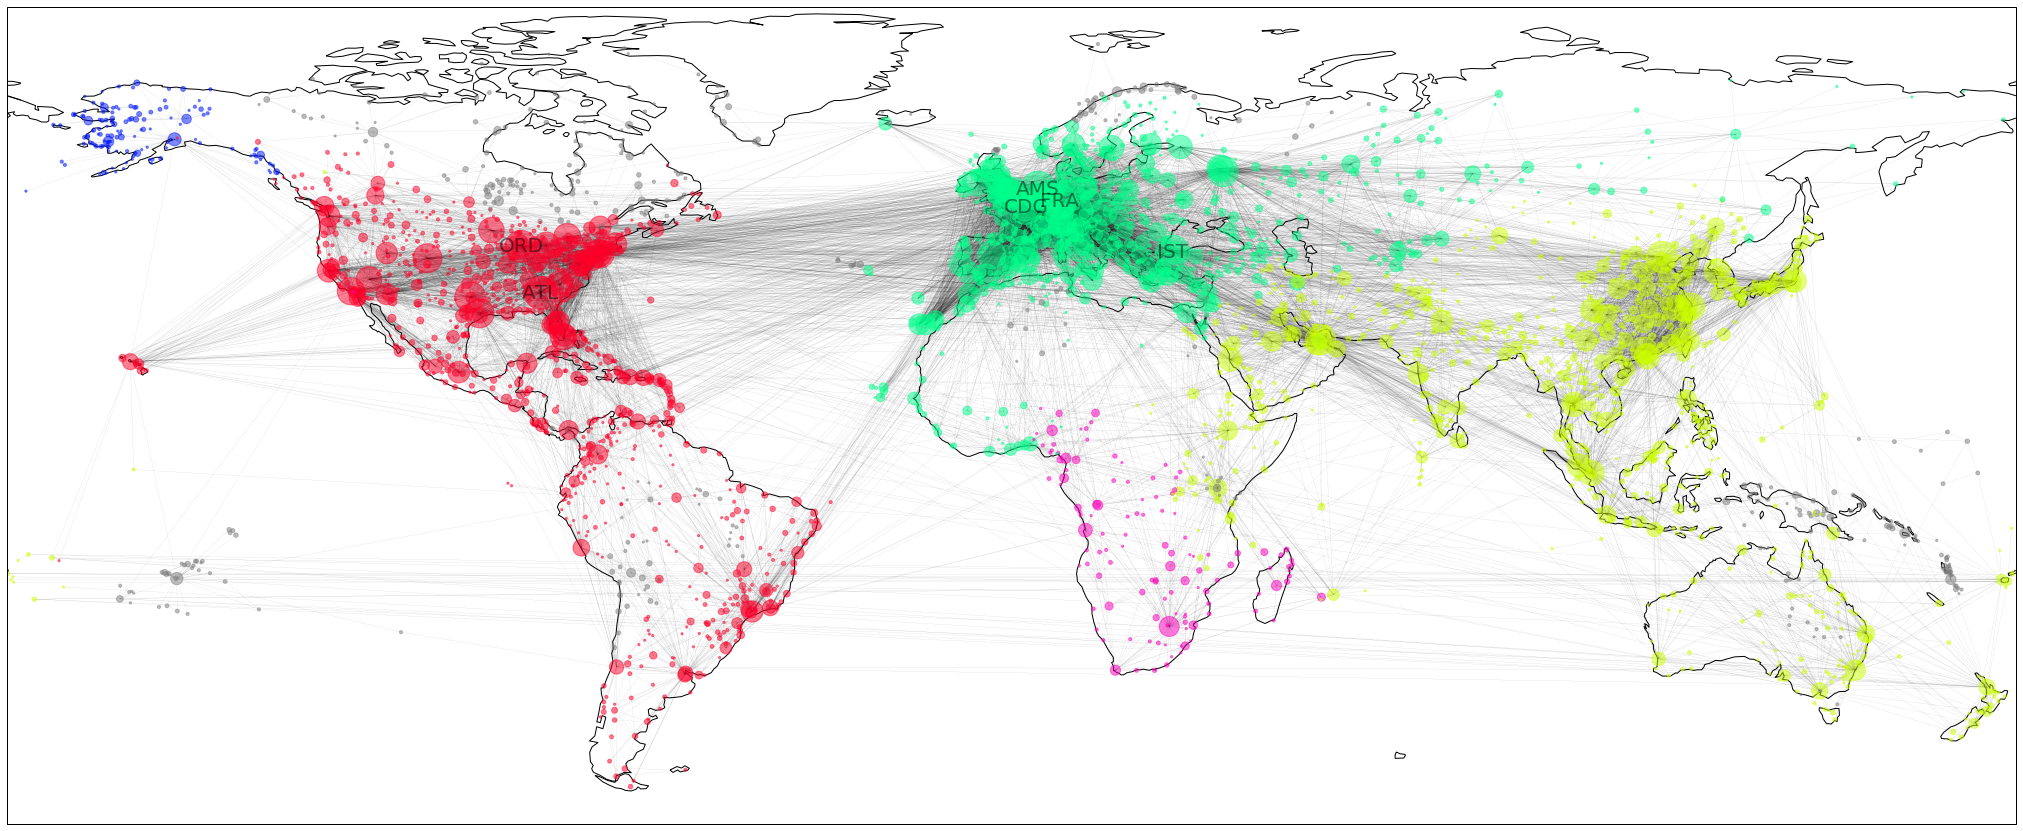

In [103]:
display_map(largest_cc, node_color=list_col)

Much better! It seems that by using the modularity, we can get better results. We see for example that Europe, America and Asia with Oceania are detected as communities. So this means that for each of these, there are way more connections inside them, compared to the number connections that leads outside of them.

## Louvain

In [9]:
def plot_community_distr(G):
    
    partition1 = nx.algorithms.community.greedy_modularity_communities(G)
    partition2 = community.best_partition(G)
    
    # Partition1
    mod_classes = np.arange(len(partition1))

    # Partition2
    c = collections.Counter(list(partition2.values()))
    k = c.keys()
    v = c.values()
    
    num_nodes = []
    for set_ in partition1:
        num_nodes.append(len(set_))
    
    plt.figure(figsize=(15,9))
    plt.scatter(mod_classes, num_nodes, label='Clauset-Newman-Moore greedy modularity maximization')
    plt.scatter(k, v, label='Louvain method')
    plt.axis([0, 41, 0, 950])
    plt.xlabel('Modularity class')
    plt.ylabel('Number of nodes')
    plt.xticks(mod_classes)
    plt.legend()
    plt.grid()

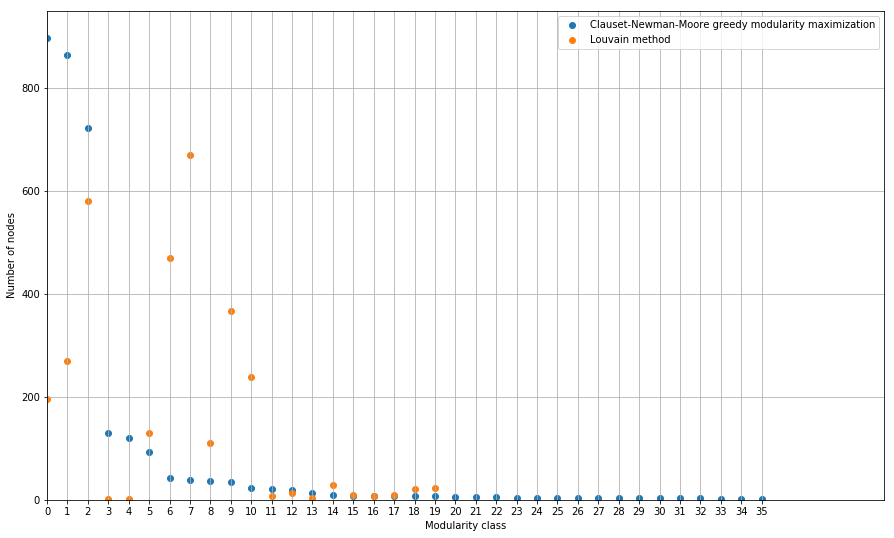

In [10]:
plot_community_distr(largest_cc)

In [156]:
#first compute the best partition
partition = community.best_partition(largest_cc)

#drawing
size = len(set(partition.values()))

cmap = plt.cm.get_cmap('gist_rainbow')
rgba = np.linspace(0.0, 1.0, num=size)
    
list_color = []
for n in largest_cc.nodes:
    list_color.append(cmap(rgba[partition[n]]))


/home/adirlou/.local/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


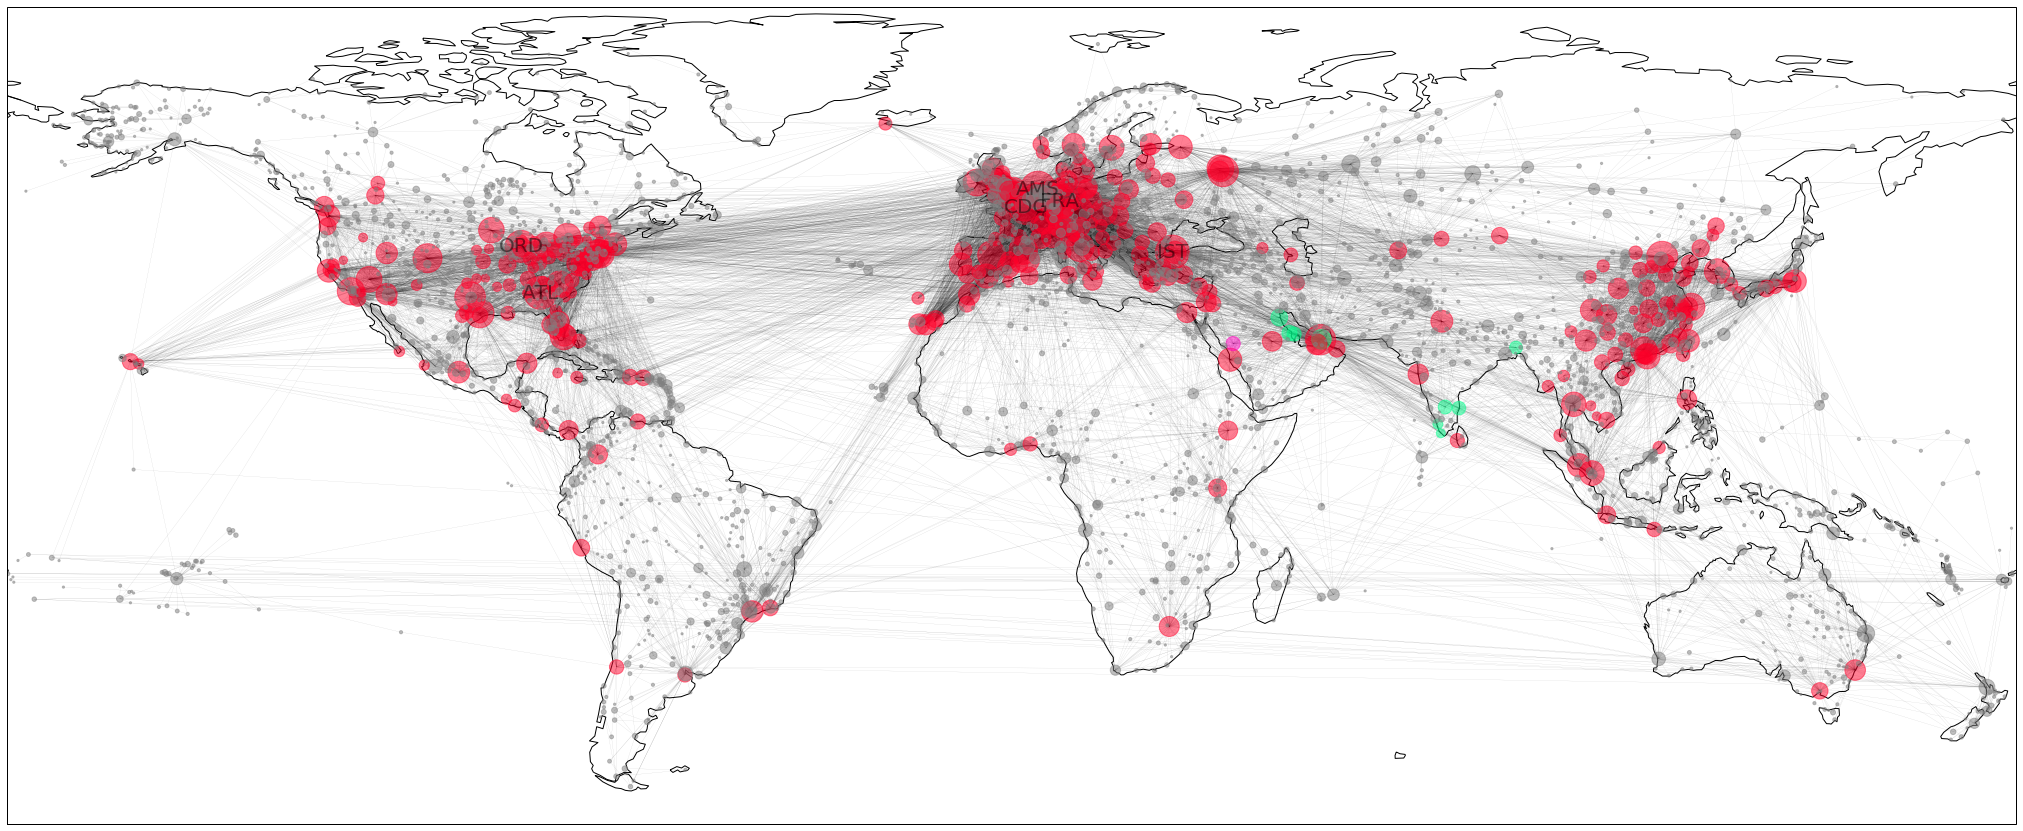

In [157]:
display_map(largest_cc, node_color=list_col)

## Girvan-Newman

Another way to distinguish communities is Girvan-Newman algorithm. It relies on shortest paths. It works the following way : We assume that esges that appear in the many shortest paths are bottleneck edges between 2 community. Thus at each step we search these edges and delete them until our graph is divided in 2.

In [27]:
graph = largest_cc.copy()
#Arbitrary number of communities : needs to be big since a lot of very small communities are created in the process
wanted_communities = 34
communities = 1 #Initialization of parameters
subgraphs = [(graph, len(graph))]

In [28]:
while communities != wanted_communities:
    #We made the assumption that we always want to divide the biggest existing community
    to_divide = subgraphs[0][0]
    subgraphs.pop(0)
    #To follow computation
    print('Communities : ', communities)
    edges_removed = 0
    while nx.is_connected(to_divide):
        
        #Remove 15% of edges at random
        edges = list(to_divide.edges)
        random.shuffle(edges)
        to_remove = edges[:int(0.15*len(edges))]
        to_divide.remove_edges_from(to_remove)
        
        #Computing edge betweenness to find edge to remove
        centrality = nx.edge_betweenness_centrality(to_divide)
        sorted_centrality = sorted(centrality.items(), key=operator.itemgetter(1), reverse=True)
        to_divide.remove_edge(sorted_centrality[0][0][0], sorted_centrality[0][0][1])
        edges_removed +=1
        print('Edges_removed : ', edges_removed)
        
        #Adding the previously removed edge for next iteration
        to_divide.add_edges_from(to_remove)
        
    subgraph = nx.connected_component_subgraphs(to_divide)#We now have divided a graph in 2 subgraphs
    for _iter in range(2):
        sub = next(subgraph)
        subgraphs.append((sub, len(sub)))
    subgraphs = sorted(subgraphs, key=lambda tup: tup[1], reverse=True)#Sorting in order to divide the biggest graph on next iteration
    communities=len(subgraphs)

In [ ]:
#Long computation, might want to save results
np.save("subgraphs", subgraphs)

In [30]:
#Picking distinguishable colors for biggest communities
colors = []
for node in largest_cc.nodes:
    cluster = 0
    while (not node in subgraphs[cluster][0]) & (cluster < 8):
        cluster +=1
    if cluster == 0:
        colors.append('tab:red')
    if cluster == 1:
        colors.append('tab:blue')
    if cluster == 2:
        colors.append('tab:green')
    if cluster == 3:
        colors.append('tab:orange')
    if cluster == 4:
        colors.append('tab:cyan')
    if cluster == 5:
        colors.append('tab:brown')
    if cluster == 6:
        colors.append('tab:olive')
    if cluster == 7:
        colors.append('tab:purple')
    if cluster == 8:#All the other communities
        colors.append('tab:gray')

/home/arnaud/anaconda3/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


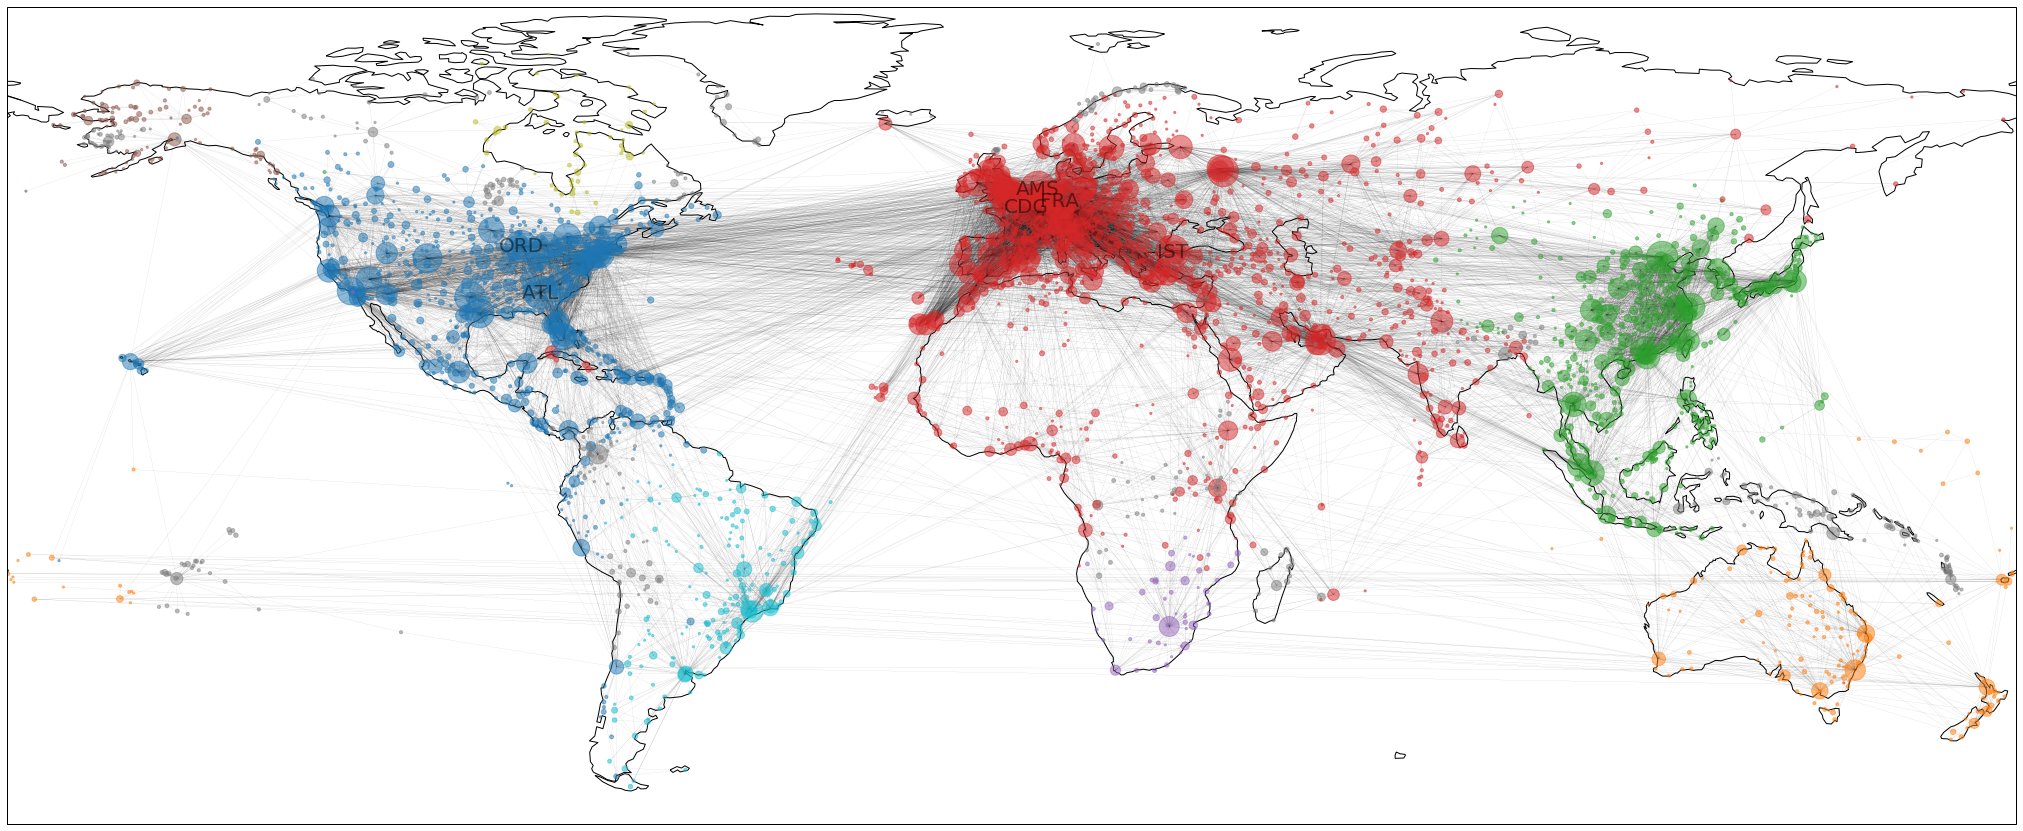

In [39]:
fig, ax = plt.subplots(
    1, 1, figsize=(36, 24),
    subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.coastlines()

nx.draw_networkx(largest_cc, ax=ax,
                 font_size=20,
                 alpha=.5,
                 width=.075,
                 node_size=sizes,
                 labels=labels,
                 pos=pos,
                node_color=colors)

Using edge betweenness to find communities yield good results. With enough communities we find back the continents we were looking for. However, this is a computationally costly method. Furthermore we had to give up on several small communities in order to finf those ones